# Importing Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import pathlib
import cv2
from tensorflow.keras import layers
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import csv
import numpy as np
import joblib

# Preparing dataset

In [2]:
#path_data = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
path_test = '../Dataset/Brain-tumor/Testing/'
path_data = '../Dataset/Brain-tumor/Training/'


path_test = pathlib.Path(path_test)
path_data = pathlib.Path(path_data)
print(path_data)

image_count = len(list(path_data.glob('*/*.jpg')))
print(image_count)

..\Dataset\Brain-tumor\Training
5712


#### Image of a brain with tumor

### Creating Testing Validation and Testing Sets

In [3]:
batch = 32
img_height = 180
img_width = 180

In [4]:
train = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'training',
seed = 42,
image_size  =(img_height,img_width),
batch_size = batch)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [7]:
val = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'validation',
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [5]:
test = tf.keras.preprocessing.image_dataset_from_directory(
path_test,
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 1311 files belonging to 4 classes.


In [8]:
print(train.class_names)
print(val.class_names)
print(test.class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']
['glioma', 'meningioma', 'notumor', 'pituitary']
['glioma', 'meningioma', 'notumor', 'pituitary']


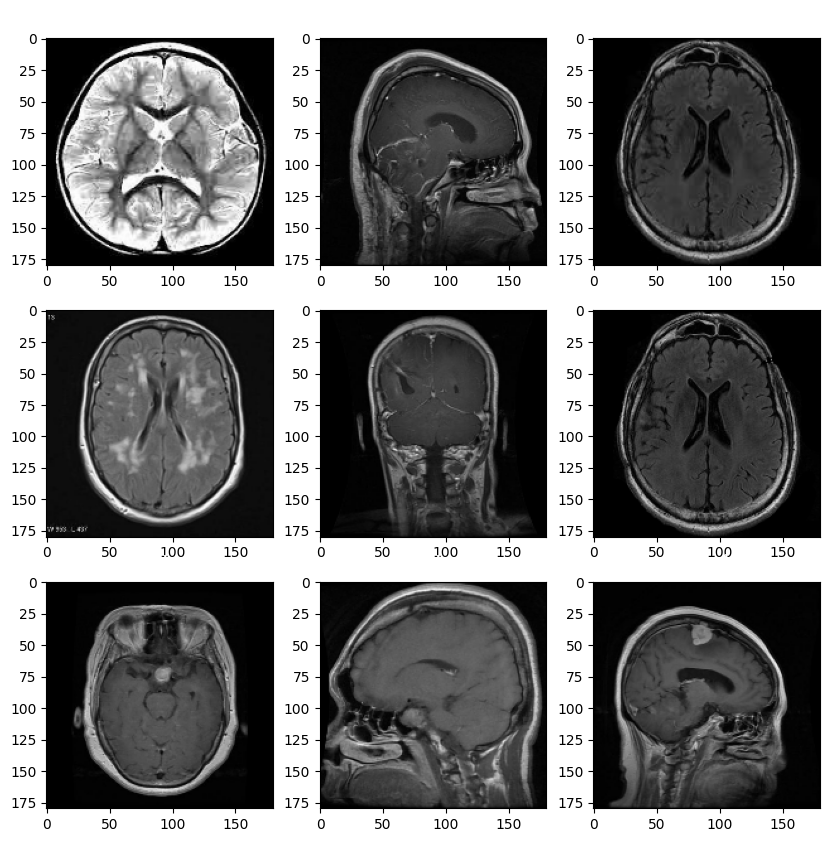

In [9]:
classes = train.class_names
plt.figure(figsize = (10,10))
for img,label in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(classes[label[i]],
                  fontdict = {'fontsize': '19',
                              'color': 'white'}
                 )
        

In [10]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

# Helper Functions
<a id='helper'></a>

In [12]:
def test_tumor(list_test_path,model):
    for path_name in list_test_path:
        test_img_path = path_name


        test_image = tf.keras.preprocessing.image.load_img(
            test_img_path, target_size=(img_height, img_width)
        )
        test_array = tf.keras.preprocessing.image.img_to_array(test_image)
        test_array = tf.expand_dims(test_array, 0) # Create a batch

        predictions = model.predict(test_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[np.argmax(score)], 100 * np.max(score))
        )

In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
conv_layer_32 = tf.keras.layers.Conv2D(32,(3,3),activation='relu')
conv_layer_64 = tf.keras.layers.Conv2D(64,3,activation='relu')
conv_layer_16 = tf.keras.layers.Conv2D(16,3,activation='relu')
max_pool = tf.keras.layers.MaxPooling2D()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [17]:
data_augmentation = tf.keras.Sequential(
  [
    normalization_layer,
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    #tf.keras.layers.RandomCrop(170,170)  
  ]
)

# Model Building

In [18]:
num_classes = 4

model = tf.keras.Sequential([
  normalization_layer,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [30]:
# Ensure the input shape is correct by adding a normalization layer at the start of the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),  # Ensure input shape is defined
    normalization_layer,  # Normalize the input to have values between 0 and 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),  # Add a Conv2D layer
    max_pool,  # Add max pooling
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),  # Add another Conv2D layer to match the expected input shape
    max_pool,  # Add another max pooling
    conv_layer_32,  # Use the pre-defined conv_layer_32 again
    max_pool,  # Add another max pooling
    layers.Flatten(),  # Flatten the output
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dense(num_classes)  # Output layer with num_classes
])

# Compile the model again after modifying its structure
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train,
    validation_data=val,
    epochs=3,
    callbacks=callback,
    shuffle=False
)
eff_epochs = len(history.history['loss'])

ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 43, 43, 32)

In [31]:
joblib.dump(model, '../Models/bt-cnn.joblib')

['../Models/bt-cnn.joblib']

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.show()

NameError: name 'history' is not defined

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 253472)            0         
                                                                 
 dense (Dense)               (None, 128)               32444544  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                      

In [33]:
results = model.evaluate(test)
print("test loss, test acc:", results)

ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 89, 89, 32)

In [34]:
list_of_paths = ['../Dataset/Brain-tumor/Testing/pituitary/Te-piTr_0007.jpg',
                '../Dataset/Brain-tumor/Testing/notumor/Te-noTr_0000.jpg',
                '../Dataset/Brain-tumor/Testing/meningioma/Te-meTr_0004.jpg',
                '../Dataset/Brain-tumor/Testing/glioma/Te-glTr_0007.jpg']
test_tumor(list_of_paths,model)

ValueError: Sequential model 'sequential_3' has already been configured to use input shape (None, 180, 180, 3). You cannot build it with input_shape (1, 180, 180, 3)

# Second Model

Adding a data augmentation layer to add more images to the training data by simply modifying the existing images in ways such as flipping them or making similar random transformations to the training data.

In [35]:
num_classes = 4

model2 = tf.keras.Sequential([
  #data_augmentation,
  normalization_layer,
  #tf.keras.layers.Conv2D(32,3,activation='relu'),
  conv_layer_32,
  layers.MaxPooling2D(pool_size=(2,2)),
  conv_layer_32,
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='softmax')
])

In [36]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
epochs = 5
# Ensure the input shape is correct by adding a normalization layer at the start of the model
model2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),  # Ensure input shape is defined
    normalization_layer,  # Normalize the input to have values between 0 and 1
    conv_layer_32,  # Use the pre-defined conv_layer_32
    layers.MaxPooling2D(pool_size=(2, 2)),
    conv_layer_32,
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model again after modifying its structure
model2.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model2.fit(
    train,
    validation_data=val,
    epochs=epochs,
    callbacks=callback,
    shuffle=False
)

ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 89, 89, 32)

In [39]:
joblib.dump(model2, '../Models/bt-cnn2.joblib')

['../Models/bt-cnn2.joblib']

In [36]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 44, 44, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [40]:
eff_epochs = len(history.history['loss'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'black'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'black'})
plt.show()

NameError: name 'history' is not defined

In [41]:
results = model2.evaluate(test)
print("test loss, test acc:", results)

ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 89, 89, 32)

## Third Model
### Using a pretrained model: MobileNetV2

In [42]:
# Create the base model from the pre-trained model MobileNet V2
image_size = (img_width,img_height)
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

C:\Users\ARTH ARVIND\AppData\Local\Temp\ipykernel_27412\1864392377.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [43]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [41]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 90, 90, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 90, 90, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 90, 90, 32)           0         ['bn_Conv1[

In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [45]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [46]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [47]:
inputs = tf.keras.Input(shape=(180, 180, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1280,activation='relu')(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [49]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
len(model.trainable_variables)

4

In [51]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(val)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 439ms/step - accuracy: 0.2881 - loss: 1.7239
initial loss: 1.68
initial accuracy: 0.30


In [52]:
history_base = model.fit(train,
                         epochs=initial_epochs,
                         validation_data=val,
                         shuffle=False
                        )

Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 523ms/step - accuracy: 0.6806 - loss: 0.7703 - val_accuracy: 0.9019 - val_loss: 0.2881
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 513ms/step - accuracy: 0.8782 - loss: 0.3234 - val_accuracy: 0.9089 - val_loss: 0.2586
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 510ms/step - accuracy: 0.9195 - loss: 0.2446 - val_accuracy: 0.9133 - val_loss: 0.2421
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 517ms/step - accuracy: 0.9223 - loss: 0.2102 - val_accuracy: 0.9133 - val_loss: 0.2255
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 508ms/step - accuracy: 0.9306 - loss: 0.1924 - val_accuracy: 0.9247 - val_loss: 0.2135


In [53]:
joblib.dump(model, '../Models/bt-mobilenet.joblib')

['../Models/bt-mobilenet.joblib']

In [54]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1280)           │     1,639,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,192,398 (27.44 MB)

 Trainable params: 1,644,804 (6.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 3,289,610 (12.55 MB)

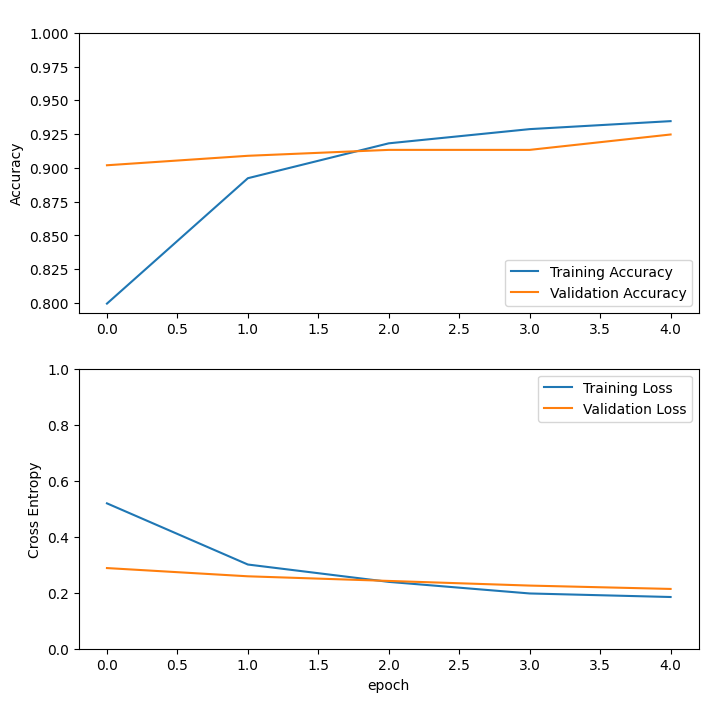

In [55]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']

loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')


plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.xlabel('epoch')
plt.show()

In [56]:
result = model.evaluate(test)
print(result)

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 421ms/step - accuracy: 0.9251 - loss: 0.2377
[0.2297266721725464, 0.9260106682777405]
